In [40]:
import pandas as pd
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [2]:
data = pd.read_csv('cyber_bully_cleaned.csv')
data.head()
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,tweet_text,cyberbullying_type
0,word katandandre food crapilicious mkr,not_cyberbullying
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying
2,xochitlsuckkks classy whore red velvet cupcake,not_cyberbullying
3,meh thanks head concerned another angry dude t...,not_cyberbullying
4,rudhoeenglish isi account pretending kurdish a...,not_cyberbullying


In [3]:
label_map = {i : l for i, l in enumerate(data['cyberbullying_type'].unique())}
label_map  
data['label'] = data['cyberbullying_type'].map({l : i for i, l in label_map.items()})
data.head()

,tweet_text,cyberbullying_type,label
0,word katandandre food crapilicious mkr,not_cyberbullying,0
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying,0
2,xochitlsuckkks classy whore red velvet cupcake,not_cyberbullying,0
3,meh thanks head concerned another angry dude t...,not_cyberbullying,0
4,rudhoeenglish isi account pretending kurdish a...,not_cyberbullying,0


In [4]:
unique_words = set()

for i, tweet in enumerate(data["tweet_text"]):
    for word in tweet.split():
        unique_words.add(word)

print(len(unique_words))
        

44043


In [5]:
word_indices = {word: i+1 for i, word in enumerate(unique_words)}

### Split data

In [6]:
def padding(sequence, max_len):
    if len(sequence) <= max_len:
        sequence = sequence + [0] * (max_len - len(sequence)) 
    
    elif len(sequence) > max_len:
        sequence = sequence[:max_len]
    
    return sequence

def prepare_data(df, word_indices, max_len):
    X = []
    y = []
    for i, row in df.iterrows():
        sequence = [word_indices[word] for word in row["tweet_text"].split() if word in word_indices]
        sequences = padding(sequence, max_len)
        X.append(sequences)
        y.append(row["label"])
    
    X = torch.tensor(X).clone().detach()
    y = torch.tensor(y).float().clone().detach()
    return X, y

In [15]:
train_size = 0.7
test_size = 0.2
val_size = 0.1

X, y = prepare_data(data, word_indices, 30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size/(test_size + val_size), random_state=12)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Word2Vec

In [7]:
# import gensim.downloader as api
# word2vec_model = api.load('word2vec-google-news-300')

In [17]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(data["tweet_text"].apply(lambda x: x.split()), min_count=1, vector_size=300, window=5, sg=1)



In [18]:
vocab_size = len(word_indices) + 1
vocab_size

44044

In [74]:
# embedding_matrix =[[0] * 300] #this matrix will contain the word embeddings for the top 5000 words #the first row will be the embedding for the padding token which is 0
# word_indices = {} #this dictionary will map each word to its index in the embedding matrix, this is needed when we train the neural network, the input to the neural network will be the index of the word in the embedding matrix
# idx = 1
# for i, word in enumerate(unique_words):
#     if word in word2vec_model.key_to_index:
#         embedding_matrix.append(word2vec_model[word])
#         word_indices[word] = idx
#         idx += 1
    
#     else:
#         continue
# embedding_matrix = np.array(embedding_matrix)
# print(embedding_matrix.shape)

(22277, 300)


In [19]:
embedding_matrix = np.zeros((vocab_size, 300))

for word in word_indices:
    if word in word2vec_model.wv:
        embedding_matrix[word_indices[word]] = word2vec_model.wv[word]
        
print(embedding_matrix.shape)

(44044, 300)


### Models

In [45]:
#LSTM 
class LSTMClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix, device):
        super(LSTMClf, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        # self.embedding.load_state_dict({'weight': torch.FloatTensor(embedding_matrix)})
        # self.embedding.weight.requires_grad = False #freeze the embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=False)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, num_classes)
        self.device = device
        
    def forward(self, x):
        #randomly initialize the hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        out = self.embedding(x)
        out, _ = self.lstm(out, (h0, c0))
        out = self.fc(out[:, -1, :]).relu()
        out = self.output(out)
        return F.log_softmax(out, dim=0)
    
    
class CNNClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, embedding_matrix):
        super(CNNClf, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=False)
        self.embedding.weight.requires_grad = False
        
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3) #output size = (input_size - kernel_size + 1) = (300 - 3 + 1) = 298 
        
        self.fc = nn.Linear(hidden_size * 298, 64)  # 298 is the output size of the convolutional layer
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        
        self.droupout = nn.Dropout(0.5)
        

        
    def forward(self, x):
        out = self.embedding(x)
        out = self.conv1(out).relu()
        out = out.flatten(1)
        out = self.droupout(out)
        out = self.fc(out).relu()
        out = self.fc2(out).relu()
        out = self.fc3(out)
        return F.log_softmax(out, dim=0)
    
    
class BiLSTMClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix, device):
        super(BiLSTMClf, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=False)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.5) 
        self.fc = nn.Linear(hidden_size * 2, 32)
        self.output = nn.Linear(32, num_classes)
        self.device = device
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0  = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)

        out = self.embedding(x)
        out, _ = self.lstm(out, (h0, c0)) 
        out = self.fc(out[:, -1, :]).relu()
        out = self.output(out)
        return F.log_softmax(out, dim=0)
    
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix, device):
        super(CNN_BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=False)

        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.pool = nn.MaxPool1d(2)
        
        self.lstm = nn.LSTM((embedding_matrix.shape[1] - 3 + 1) // 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 32)
        self.output = nn.Linear(32, num_classes)
        self.device = device

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)

        out = self.embedding(x)

        out = self.conv1(out).relu()
        out = self.bn(out)
        out = self.pool(out)
        
        out, _ = self.lstm(out, (h0, c0))
        out = self.fc(out[:, -1, :]).relu()
        out = self.output(out)
        return F.log_softmax(out, dim=0)

In [42]:
def train(train_data, validation_data, criterion, optimizer, device, model, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        train_corr = 0
        total_train = 0

        for x, y in train_data:
            # Send data to the correct device
            x, y = x.to(device), y.to(device).long()
            total_train += y.size(0)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item() 

            #Compute train accuracy
            pred = torch.argmax(output, 1)
            train_corr += (pred == y).sum().item()
            
            loss.backward()
            optimizer.step()
        
        train_losses.append(total_loss / len(train_data))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in validation_data:
                x, y = x.to(device), y.to(device).long()
                output = model(x)
                val_loss += criterion(output, y).item()
            
            val_losses.append(val_loss / len(validation_data))
        
        # #Display metrics
        train_accuracy = 100 * train_corr / total_train
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_losses[-1]:.4f}")


    return train_losses, val_losses


def test(test_data, model, device):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for x, y in test_data:
            x, y = x.to(device), y.to(device).long()
            output = model(x)
            pred = torch.argmax(output, 1)
            
            # Collect predictions and true labels as lists of integers
            y_pred.extend(pred.int().cpu().tolist())
            y_true.extend(y.int().cpu().tolist())

    # Ensure that y_true is the first argument in the metric functions
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    report = classification_report(y_true, y_pred, target_names=label_map.values())
    

    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(report)
    return accuracy, precision, recall, f1

In [28]:
#hyperparameters
input_size = 300
hidden_size = 16
num_layers = 2
num_classes = 5
learning_rate = 0.001
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.NLLLoss()
dl_results = {} #store the results of the different models


cuda


Training LSTMClf
Epoch 1/5, Training Loss: 2.5732, Train Accuracy: 74.28%, Validation Loss: 2.1895
Epoch 2/5, Training Loss: 2.1226, Train Accuracy: 94.11%, Validation Loss: 2.1330
Epoch 3/5, Training Loss: 2.0377, Train Accuracy: 96.74%, Validation Loss: 2.1544
Epoch 4/5, Training Loss: 1.9948, Train Accuracy: 98.19%, Validation Loss: 2.2054
Epoch 5/5, Training Loss: 1.9708, Train Accuracy: 98.66%, Validation Loss: 2.2162
Test Accuracy: 0.9270, Precision: 0.9272, Recall: 0.9270, F1 Score: 0.9271
                   precision    recall  f1-score   support

not_cyberbullying       0.83      0.84      0.83      1553
           gender       0.90      0.89      0.90      1556
         religion       0.95      0.95      0.95      1581
              age       0.98      0.97      0.97      1656
        ethnicity       0.97      0.99      0.98      1491

         accuracy                           0.93      7837
        macro avg       0.93      0.93      0.93      7837
     weighted avg       

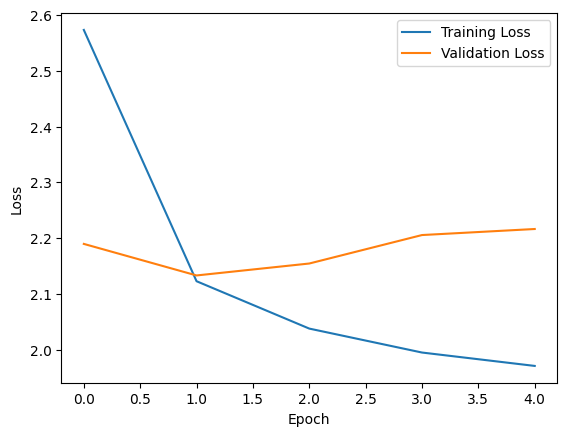

In [43]:
lstm_clf = LSTMClf(input_size, hidden_size, num_layers, num_classes, embedding_matrix, device).to(device)

model = lstm_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs=5)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
    

Training CNNClf
Epoch 1/10, Training Loss: 2.3329, Train Accuracy: 85.68%, Validation Loss: 2.1798
Epoch 2/10, Training Loss: 2.1907, Train Accuracy: 89.37%, Validation Loss: 2.1416
Epoch 3/10, Training Loss: 2.1795, Train Accuracy: 89.62%, Validation Loss: 2.1475
Epoch 4/10, Training Loss: 2.1657, Train Accuracy: 90.13%, Validation Loss: 2.1716
Epoch 5/10, Training Loss: 2.1583, Train Accuracy: 90.32%, Validation Loss: 2.1350
Epoch 6/10, Training Loss: 2.1517, Train Accuracy: 90.50%, Validation Loss: 2.1359
Epoch 7/10, Training Loss: 2.1453, Train Accuracy: 90.86%, Validation Loss: 2.1289
Epoch 8/10, Training Loss: 2.1417, Train Accuracy: 90.92%, Validation Loss: 2.1337
Epoch 9/10, Training Loss: 2.1345, Train Accuracy: 91.16%, Validation Loss: 2.1295
Epoch 10/10, Training Loss: 2.1322, Train Accuracy: 91.15%, Validation Loss: 2.1207
Test Accuracy: 0.9165, Precision: 0.9242, Recall: 0.9165, F1 Score: 0.9174
                   precision    recall  f1-score   support

not_cyberbullying 

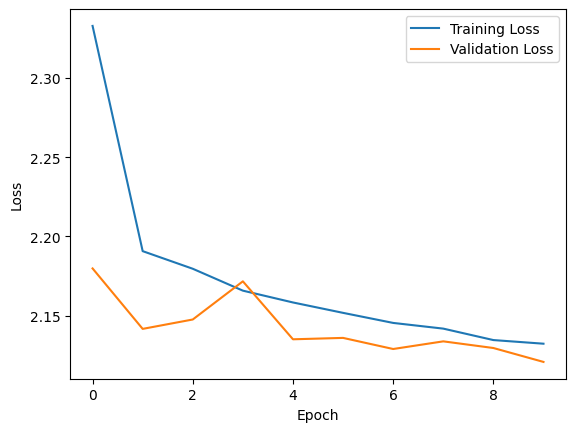

In [46]:
cnn_clf = CNNClf(30, hidden_size, num_classes, embedding_matrix).to(device)

model = cnn_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs=10)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Training BiLSTMClf
Epoch 1/5, Training Loss: 2.5632, Train Accuracy: 73.77%, Validation Loss: 2.1783
Epoch 2/5, Training Loss: 2.1097, Train Accuracy: 94.14%, Validation Loss: 2.1257
Epoch 3/5, Training Loss: 2.0231, Train Accuracy: 96.96%, Validation Loss: 2.1351
Epoch 4/5, Training Loss: 1.9857, Train Accuracy: 98.30%, Validation Loss: 2.1652
Epoch 5/5, Training Loss: 1.9633, Train Accuracy: 98.91%, Validation Loss: 2.2183
Test Accuracy: 0.9275, Precision: 0.9268, Recall: 0.9275, F1 Score: 0.9270
                   precision    recall  f1-score   support

not_cyberbullying       0.85      0.81      0.83      1553
           gender       0.89      0.91      0.90      1556
         religion       0.95      0.95      0.95      1581
              age       0.97      0.98      0.97      1656
        ethnicity       0.98      0.99      0.98      1491

         accuracy                           0.93      7837
        macro avg       0.93      0.93      0.93      7837
     weighted avg     

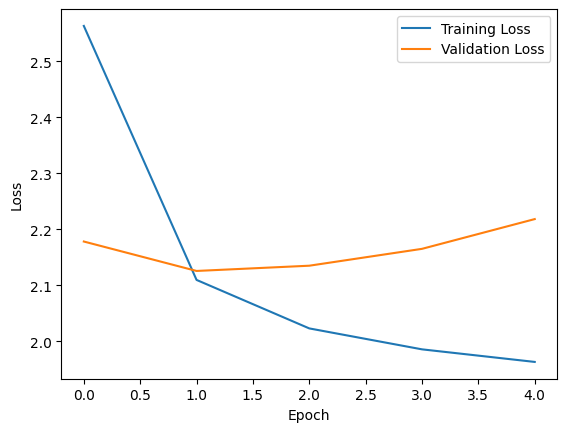

In [47]:
bi_lstm_clf = BiLSTMClf(input_size, hidden_size, num_layers, num_classes, embedding_matrix, device).to(device)

model = bi_lstm_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs=5)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Training CNN_BiLSTM
Epoch 1/5, Training Loss: 2.2947, Train Accuracy: 87.80%, Validation Loss: 2.1155
Epoch 2/5, Training Loss: 2.0301, Train Accuracy: 96.42%, Validation Loss: 2.1172
Epoch 3/5, Training Loss: 1.9642, Train Accuracy: 98.76%, Validation Loss: 2.1535
Epoch 4/5, Training Loss: 1.9361, Train Accuracy: 99.53%, Validation Loss: 2.2103
Epoch 5/5, Training Loss: 1.9290, Train Accuracy: 99.71%, Validation Loss: 2.2775
Test Accuracy: 0.9274, Precision: 0.9267, Recall: 0.9274, F1 Score: 0.9269
                   precision    recall  f1-score   support

not_cyberbullying       0.84      0.82      0.83      1553
           gender       0.92      0.88      0.90      1556
         religion       0.94      0.97      0.95      1581
              age       0.96      0.98      0.97      1656
        ethnicity       0.97      0.99      0.98      1491

         accuracy                           0.93      7837
        macro avg       0.93      0.93      0.93      7837
     weighted avg    

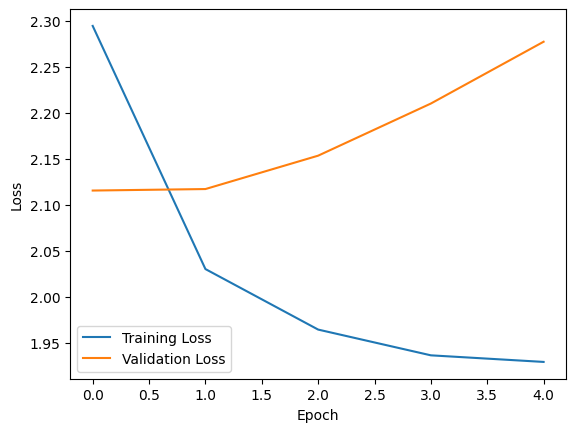

In [48]:
cnn_bilstm_clf = CNN_BiLSTM(30, hidden_size, num_layers, num_classes, embedding_matrix, device).to(device)

model = cnn_bilstm_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs=5)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [49]:
results = pd.DataFrame(dl_results).T
results


,accuracy,precision,recall,f1
LSTMClf,0.927013,0.927181,0.927013,0.927075
CNNClf,0.916550,0.924151,0.916550,0.917421
BiLSTMClf,0.927523,0.926759,0.927523,0.926967
CNN_BiLSTM,0.927396,0.926739,0.927396,0.926882
